In [40]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
# Example time series data (replace this with your actual data)
data = pd.read_csv(r'dataset.csv',parse_dates=True,index_col=0)
# # data = np.sin(np.linspace(0, 100, 1000))  # Example sine wave data
# test_data = pd.read_csv(r'test_data.csv',parse_dates=True,index_col=0).values

seq_length = 12

train_breakpoint = int(len(data)*0.7)

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(data.iloc[:train_breakpoint,:])

data_scaled = scaler.transform(data)
# data_scaled = data.values

# data_scaled = data.values


def create_sequences_dataloader(data, seq_length,batch_size = 64, shuffle = True):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    X = torch.from_numpy(np.array(sequences,dtype=np.float32).reshape(-1,seq_length,1))
    y = torch.from_numpy(np.array(labels,dtype=np.float32))
    dataset = TensorDataset(X,y)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
    return dataloader



dataloader_trend = create_sequences_dataloader(data_scaled[:train_breakpoint,1],seq_length)
dataloader_seasonal = create_sequences_dataloader(data_scaled[:train_breakpoint,2],seq_length)
dataloader_res = create_sequences_dataloader(data_scaled[:train_breakpoint,3],seq_length)
dataloader_trend_test = create_sequences_dataloader(data_scaled[train_breakpoint:,1],seq_length,1,False)
dataloader_seasonal_test = create_sequences_dataloader(data_scaled[train_breakpoint:,2],seq_length,1,False)
dataloader_res_test = create_sequences_dataloader(data_scaled[train_breakpoint:,3],seq_length,1,False)
dataloader_test = create_sequences_dataloader(data_scaled[train_breakpoint:,0],seq_length,1,False)


In [41]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        out = self.fc(out)
        return out


In [45]:
# Hyperparameters
input_size = 1  # One feature per time step
hidden_size = 32
num_layers = 2
output_size = 1  # Predict the next value in the series
learning_rate = 0.001
epochs = 100

def train_model(model,dataloader,learning_rate,epochs=100):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in dataloader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(X_batch)

            # Compute the loss
            loss = criterion(output, y_batch)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Instantiate the model
model_trend = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
train_model(model_trend,dataloader_trend,learning_rate,epochs)
model_seasonal = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
train_model(model_seasonal,dataloader_seasonal,learning_rate,epochs)
model_residuals = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
train_model(model_residuals,dataloader_res,learning_rate,epochs)




Epoch [100/100], Loss: 0.0893
Epoch [100/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0152


In [46]:
# Prediction for the next value
def predict_model(model,dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            predictions.append(model(X_batch).numpy())
    return np.array(predictions).flatten()
    # return predictions

# dataloader_trend_temp = create_sequences_dataloader(data_scaled[:train_breakpoint,1],seq_length,batch_size=1)
trend_predictions = predict_model(model_trend,dataloader_trend_test)
residual_predictions = predict_model(model_residuals,dataloader_res_test)
seasonal_predictions = predict_model(model_seasonal,dataloader_seasonal_test)




((131,), (143, 4))

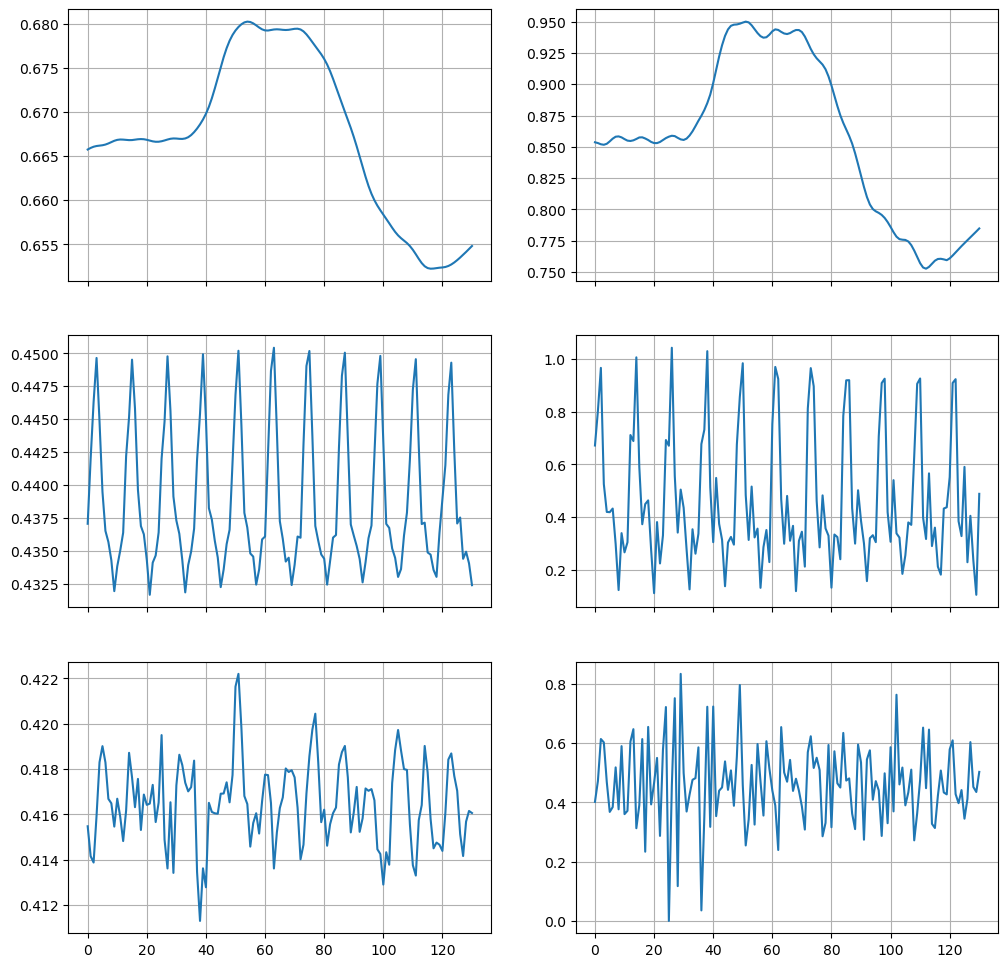

: 

In [ ]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(3,2,sharex=True,figsize=(12,12))

# 
# predictions = trend_predictions + residual_predictions + seasonal_predictions

axes[0,0].plot(trend_predictions)
axes[0,1].plot(data_scaled[train_breakpoint+seq_length:,1])
axes[1,0].plot(seasonal_predictions)
axes[1,1].plot(data_scaled[train_breakpoint+seq_length:,2])
axes[2,0].plot(residual_predictions)
axes[2,1].plot(data_scaled[train_breakpoint+seq_length:,3])

[ax.grid(True) for ax in axes.flatten()]
# plt.figure()
# plt.plot(data_scaled[:,0])


trend_predictions.shape,data_scaled[train_breakpoint:].shape
